In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

In [5]:
path_lbl.ls()

[PosixPath('/home/jupyter/.fastai/data/camvid/labels/0001TP_009180_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/Seq05VD_f01110_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_08115_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_07200_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_07020_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_05340_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_08087_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/Seq05VD_f05100_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/Seq05VD_f04470_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_01440_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0006R0_f01140_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_05190_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_04830_P.png'),
 PosixPath('/home

In [6]:
# Data

In [7]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/images/Seq05VD_f01950.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_05970.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_08400.png')]

In [8]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/labels/0001TP_009180_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/Seq05VD_f01110_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_08115_P.png')]

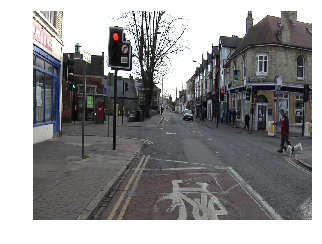

In [9]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [10]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [11]:
# get mask file
mask_f = get_y_fn(img_f); mask_f

PosixPath('/home/jupyter/.fastai/data/camvid/labels/Seq05VD_f01950_P.png')

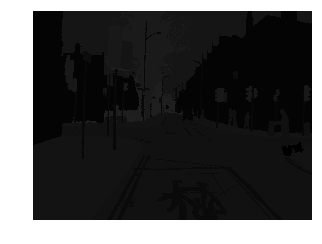

In [12]:
# try to show mask png image file using normal open_image
mask_img = open_image(mask_f)
mask_img.show(figsize=(5,5), alpha=1)
# error show black image ???

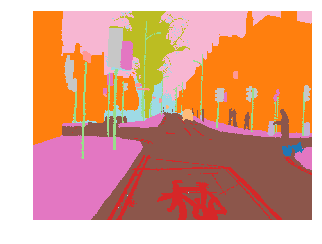

In [13]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [14]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [15]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [16]:
# Datasets

In [17]:
size = src_size//2
bs = 8

In [18]:
src = (SegmentationItemList.from_folder(path_img)
      .split_by_fname_file('../valid.txt')
      .label_from_func(get_y_fn, classes=codes))

In [19]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

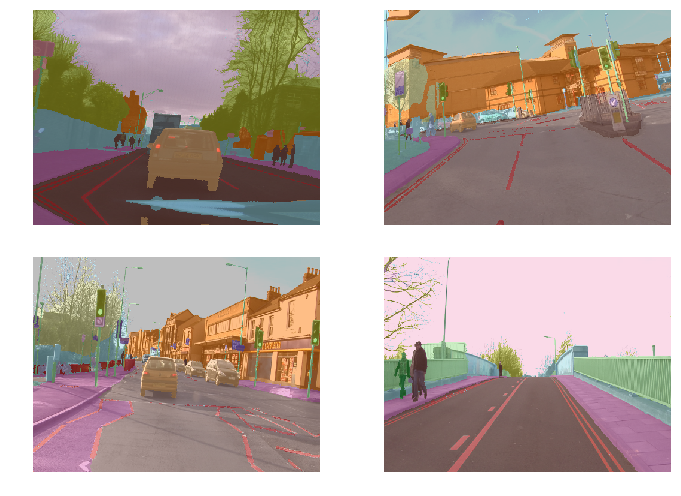

In [20]:
data.show_batch(2, figsize=(10,7))

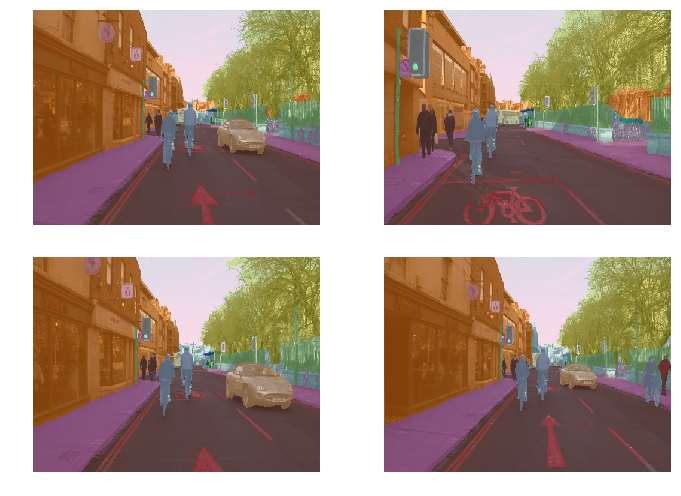

In [21]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [22]:
# MOdel

In [23]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [24]:
metrics=acc_camvid
# metrics=accuracy

In [25]:
wd=1e-2

In [26]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()

In [27]:
lr_find(learn)

/opt/anaconda3/lib/python3.7/site-packages/fastai/callbacks/fp16.py:97: UserWarning: You have a `loss_scale` factor that is too high, try to divide it by 2 (current value: 512).
  warn(f"You have a `loss_scale` factor that is too high, try to divide it by 2 (current value: {self.loss_scale}).")


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.75E-04


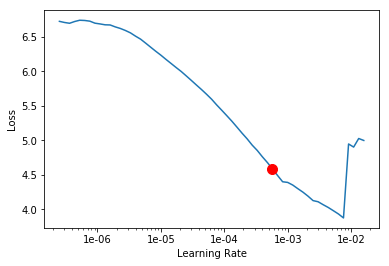

In [28]:
learn.recorder.plot(skip_start=5, skip_end=2)

In [29]:
lr=3e-3

In [30]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid
1,1.378983,0.852111,0.799820
2,0.867535,0.620206,0.838985
3,0.701452,0.604219,0.850300
4,0.679050,0.497308,0.864003
5,0.615146,0.561473,0.864598
6,0.606179,0.664833,0.813409
7,0.902242,0.688913,0.842694
8,0.679741,0.484378,0.879235
9,0.566398,0.449199,0.873525
10,0.495237,0.363907,0.894081


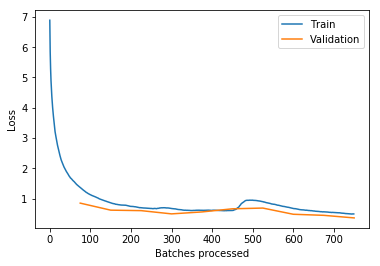

In [31]:
learn.recorder.plot_losses()

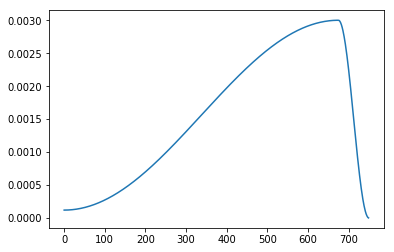

In [32]:
learn.recorder.plot_lr()

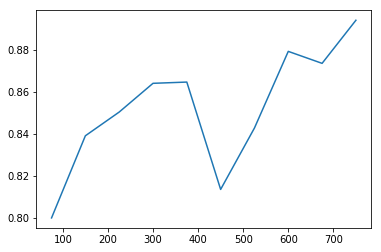

In [35]:
learn.recorder.plot_metrics()

In [36]:
learn.save('stage-1')

In [37]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/jupyter/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/jupyter/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [38]:
learn.show_results(rows=3, figsize=(8,9))

RuntimeError: expected type torch.FloatTensor but got torch.HalfTensor

In [39]:
learn.unfreeze()

In [40]:
lrs = slice(lr/400, lr/4)

In [42]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.428720,0.353337,0.896542
2,0.415511,0.341514,0.899781
3,0.408628,0.334282,0.901526
4,0.391039,0.321646,0.907357
5,0.384233,0.333487,0.901135
6,0.371590,0.323146,0.904152
7,0.358479,0.314275,0.912939
8,0.346264,0.298056,0.917243
9,0.335044,0.321456,0.904393
10,0.325218,0.358663,0.892611


In [43]:
learn.recorder.plot_losses()

[autoreload of matplotlib failed: Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 376, in superreload
    module = reload(module)
  File "/opt/anaconda3/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/opt/anaconda3/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/opt/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py", line 1099, in <module>
    rcParams = rc_params()
  File "/opt/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py", line 950, 

[autoreload of fastai.gen_doc.nbdoc failed: Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 376, in superreload
    module = reload(module)
  File "/opt/anaconda3/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/opt/anaconda3/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/opt/anaconda3/lib/python3.7/site-packages/fastai/gen_doc/nbdoc.py", line 12, in <module>
    from .nbtest import get_pytest_html
  File "/opt/anaconda3/lib/python3.7/site-packages/fastai/gen_do

ValueError: 'transform' must be an instance of 'matplotlib.transform.Transform'

In [ ]:
learn.recorder.plot_lr()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.show_results(rows=3, figsize=(8,9))

In [ ]:
learn.save('stage-2')

In [ ]:
# Go big

In [ ]:
size = src_size
bs=2

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()

In [ ]:
learn.load('stage-2')

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [40]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.384628,0.316870,0.913192
2,0.347608,0.342100,0.909110
3,0.325934,0.348501,0.900755
4,0.350072,0.309866,0.909098
5,0.361019,0.335928,0.904897
6,0.353615,0.366900,0.895593
7,0.328947,0.314529,0.917946
8,0.344025,0.275410,0.926677
9,0.287106,0.308023,0.922171
10,0.235801,0.257152,0.928200


In [41]:
learn.save('stage-1-big')

In [42]:
learn.load('stage-1-big')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/jupyter/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/jupyter/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [43]:
learn.unfreeze()

In [44]:
lrs = slice(1e-6, lr/10)

In [45]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.222317,0.256462,0.929086
2,0.215080,0.248935,0.930605
3,0.226207,0.271924,0.927109
4,0.208213,0.262496,0.928407
5,0.226461,0.247132,0.930528
6,0.193437,0.255059,0.930777
7,0.196490,0.252773,0.932255
8,0.190482,0.254571,0.931446
9,0.194523,0.250386,0.931996
10,0.188730,0.249066,0.932880


In [46]:
learn.save('stage-2-big')

In [47]:
learn.load('stage-2-big')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/jupyter/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/jupyter/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

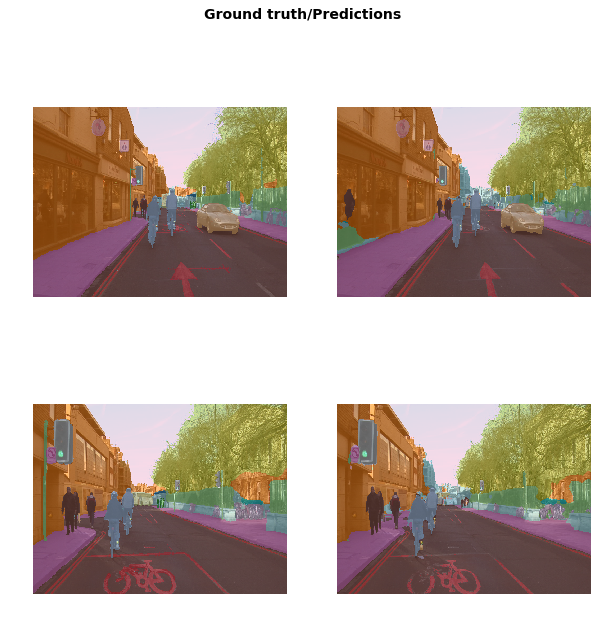

In [48]:
learn.show_results(rows=3, figsize=(10,10))